In [125]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

sns.set_style("whitegrid")

## Load Data

In [126]:
data_folder = '../'

train_file = 'train.csv'
test_file = 'test.csv'

train_path = data_folder + train_file
test_path = data_folder + test_file

In [127]:
df_train = pd.read_csv(train_path).rename(columns={'KPI ID': 'kpi_id'})
print(df_train.shape)
df_train.head(2)

(2476315, 4)


,timestamp,value,label,kpi_id
0,1493568000,1.901639,0,02e99bd4f6cfb33f
1,1493568060,1.786885,0,02e99bd4f6cfb33f


In [128]:
df_test = pd.read_csv(test_path).rename(columns={'KPI ID': 'kpi_id'})
print(df_test.shape)
df_test.head(2)

(2345211, 3)


,timestamp,value,kpi_id
0,1501475700,2.719298,02e99bd4f6cfb33f
1,1501475760,2.456140,02e99bd4f6cfb33f


In [129]:
df_train['datetime'] = pd.to_datetime(df_train.timestamp, unit='s')
df_test['datetime'] = pd.to_datetime(df_test.timestamp, unit='s')

## Pre-processing

#### fill na

In [130]:
df_train.isna().sum(axis=0)

timestamp    0
value        0
label        0
kpi_id       0
datetime     0
dtype: int64

In [131]:
df_test.isna().sum(axis=0)

timestamp    0
value        0
kpi_id       0
datetime     0
dtype: int64

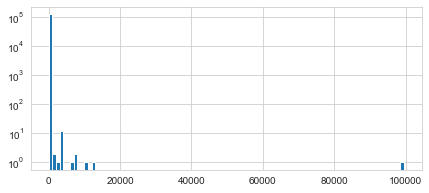

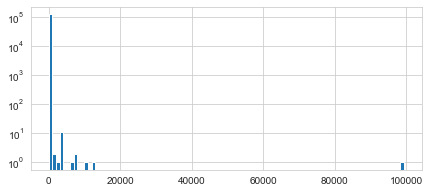

kpi_id
02e99bd4f6cfb33f    (AxesSubplot(0.125,0.125;0.775x0.755), None)
9bd90500bfd11edb    (AxesSubplot(0.125,0.125;0.775x0.755), None)
dtype: object

In [132]:
# Plot the time interval between timestamps for each kpi_id. Train set

df_train[df_train.kpi_id.isin(df_train.kpi_id.unique()[:2])].groupby('kpi_id').apply(lambda x:
                                                                                     (x.timestamp.diff().hist(log=True, bins=100, figure=plt.figure(figsize=(7, 3))), plt.show()))

In [133]:
df_train.timestamp.diff().value_counts().iloc[:3]

60.0     2388846
300.0      62321
120.0      23594
Name: timestamp, dtype: int64

The target frequency seems to be one minute

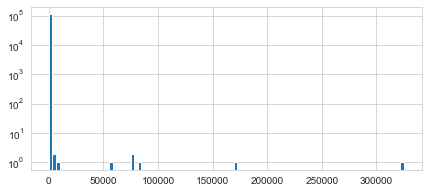

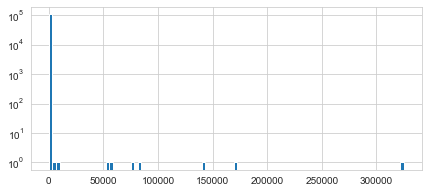

kpi_id
02e99bd4f6cfb33f    (AxesSubplot(0.125,0.125;0.775x0.755), None)
9bd90500bfd11edb    (AxesSubplot(0.125,0.125;0.775x0.755), None)
dtype: object

In [134]:
# Plot the time interval between timestamps for each kpi_id. Test set

df_test[df_test.kpi_id.isin(df_test.kpi_id.unique()[:2])].groupby('kpi_id').apply(lambda x:
                                                                                     (x.timestamp.diff().hist(log=True, bins=100, figure=plt.figure(figsize=(7, 3))), plt.show()))

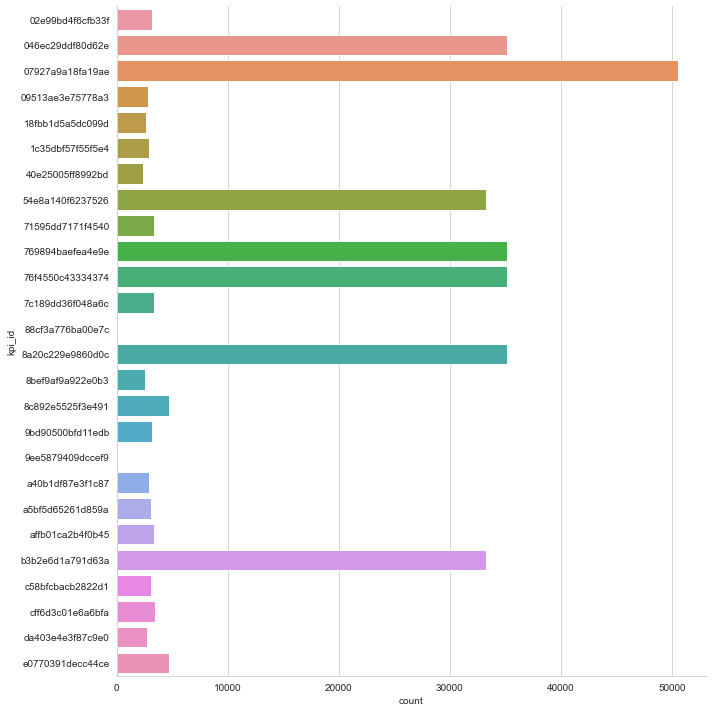

In [135]:
# Plot the number of missing dates (with 1min interval) for each kpi

missing_date_per_kip = df_train.groupby('kpi_id').apply(lambda x: pd.Series(pd.date_range(start=x.datetime.min(), end=x.datetime.max(), freq='1min').difference(x.datetime))).reset_index(drop=False)
missing_date_per_kip = missing_date_per_kip.rename(columns={0: 'datetime'}).drop(columns=['level_1'])
sns.catplot(y='kpi_id', x=None, data=missing_date_per_kip, kind='count', orient='h', height=10)

In [136]:
# Create missing date and fill na of these newly created dates

def fill_na(data):
    start = data.datetime.min()
    end = data.datetime.max()
    idx = pd.date_range(start=start, end=end, freq='1min')
    data.set_index('datetime', inplace=True)
    data = data.reindex(idx)

    data.timestamp = (data.index.astype(int) / 10 ** 9)
    data.kpi_id = data.kpi_id.unique()[0]

    data.fillna(method="ffill", inplace=True)  # ffill: propagate last valid observation forward to next valid
    return data.reset_index(drop=False).rename(columns={'index': 'datetime'})

df_train = df_train.groupby('kpi_id').apply(fill_na).reset_index(drop=True)
df_train.head(2)

,datetime,timestamp,value,label,kpi_id
0,2017-04-30 16:00:00,1.493568e+09,1.901639,0.0,02e99bd4f6cfb33f
1,2017-04-30 16:01:00,1.493568e+09,1.786885,0.0,02e99bd4f6cfb33f


In [137]:
# Check there is not missing date anymore

missing_date_per_kip = df_train.groupby('kpi_id').apply(lambda x: pd.Series(pd.date_range(start=x.datetime.min(), end=x.datetime.max(), freq='1min').difference(x.datetime).size)).reset_index(drop=False).rename(columns={0: 'missing_dates'})

print(f"any missing date? {missing_date_per_kip.missing_dates.any()}")


any missing date? False


#### scaling

In [138]:
# TODO

### Export

In [139]:
# Export preprocessed file

df_train.to_csv(data_folder + 'df_train_preprocessed.csv')